In [19]:
import pandas as pd

# This script loads the data from the CSV files generated by the querying the journal database (Web of Science).

# The CSV files are saved in the Data directory.
directory = './Data'

# Weird encoding issue with the first query. Might have saved it using a Mac filesystem.
# The rest of the queries are saved using a Windows filesystem.
combined_df = pd.concat([
    pd.read_csv(f'{directory}/Query1.csv', sep=',', encoding='utf-8-sig', low_memory=False).rename(columns=lambda x: x.strip()),
    pd.read_csv(f'{directory}/Query2.csv', sep=',', encoding='ISO-8859-1', low_memory=False).rename(columns=lambda x: x.strip()),
    pd.read_csv(f'{directory}/Query3.csv', sep=',', encoding='ISO-8859-1', low_memory=False).rename(columns=lambda x: x.strip()),
    pd.read_csv(f'{directory}/Query4.csv', sep=',', encoding='ISO-8859-1', low_memory=False).rename(columns=lambda x: x.strip()),
    pd.read_csv(f'{directory}/Query5.csv', sep=',', encoding='ISO-8859-1', low_memory=False).rename(columns=lambda x: x.strip())
], ignore_index=True)

#Labels the abstracts. The first 200 are "AI and Supply Chain Management", the next 200 are "AI and Finance", the next 200 are "AI and Marketing", the next 200 are "AI and Economics", and the last 200 are "AI and Accounting".
combined_df['Label'] = ['AI and Supply Chain Management'] * 200 + \
                       ['AI and Finance'] * 200 + \
                       ['AI and Marketing'] * 200 + \
                       ['AI and Economics'] * 200 + \
                       ['AI and Accounting'] * 200

# Defines the columns to keep from the combined dataframe.
columns = ['Authors', 'Publication Year', 'Article Title', 'Abstract', 'Label']

# Selects the columns from the combined dataframe.
clean_df = combined_df[columns]

# Shows the dataframe and confirms that the data is loaded and the correct columns are selected.
clean_df

,Authors,Publication Year,Article Title,Abstract,Label
0,"Daios, A; Kladovasilakis, N; Kelemis, A; Kosta...",2025,AI Applications in Supply Chain Management: A ...,The advent of Industry 4.0 and the integration...,AI and Supply Chain Management
1,"El Haoud, N; Bachiri, Z",2019,Stochastic Artificial Intelligence benefits an...,Supply chain management (SCM) includes several...,AI and Supply Chain Management
2,"Wamba, SF; Queiroz, MM; Guthrie, C; Braganza, A",2022,Industry experiences of artificial intelligenc...,This editorial aims to present the papers acce...,AI and Supply Chain Management
3,"Hangl, J; Behrens, VJ; Krause, S",2022,"Barriers, Drivers, and Social Considerations f...",Background: The number of publications in supp...,AI and Supply Chain Management
4,"Shrivastav, M",2022,Barriers Related to AI Implementation in Suppl...,The primary objective of this paper is to offe...,AI and Supply Chain Management
...,...,...,...,...,...
995,"Santos, CR; Azevedo, G; Marques, RP",2024,A Guide to Identifying Artificial Intelligence...,Artificial Intelligence (AI) is a topic that h...,AI and Accounting
996,"Qasim, A; El Refae, GA; Issa, H; Eletter, S",2021,The Impact of Drone Technology on The Accounti...,The accounting profession has gone through rad...,AI and Accounting
997,"Kane, S; Moody, V; Harradon, M",2021,Towards Incorporating AI into the Mission Plan...,While there are numerous powerful tools to sup...,AI and Accounting
998,"Young, A; Tan, KV; Tariq, F; Fin, MX; Blueston...",2024,Rogue AI: Cautionary Cases in Neuroradiology a...,"Introduction In recent years, artificial intel...",AI and Accounting


In [20]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re

# Download required NLTK resources
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Initialize TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False)

# Function to clean abstract text
def clean_text(text):
    if not isinstance(text, str):
        return ''

    # Lowercase and remove unwanted characters except apostrophes and periods
    text = re.sub(r"[^a-zA-Z0-9\s'.]", ' ', text)
    text = re.sub(r"(?<!\d)\.(?!\d)", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove apostrophes that follow a space (fix tokenization artifacts)
    text = re.sub(r"\s+'", '', text)

    # Tokenize with TweetTokenizer (preserves contractions like "don't")
    words = tokenizer.tokenize(text)

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Join back to string
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

# Example: assuming your DataFrame is called `clean_df`
clean_df = clean_df.copy()
clean_df['Cleaned Abstract'] = clean_df['Abstract'].apply(clean_text)

# Count total number of words across all cleaned abstracts
total_words = clean_df['Cleaned Abstract'].apply(lambda x: len(x.split())).sum()

print(f"Total number of words in all cleaned abstracts: {total_words}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/etienne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total number of words in all cleaned abstracts: 123265


In [ ]:
partitions = []
words_per_partition = 150

# Iterate through each row in the dataframe
for _, row in clean_df.iterrows():
    cleaned_text = row['Cleaned Abstract']
    if not cleaned_text:
        continue

    words = cleaned_text.split()

    for i in range(0, len(words), words_per_partition):
        partition_text = ' '.join(words[i:i+words_per_partition])
        partitions.append({
            'Title': row['Article Title'],
            'Year': row['Publication Year'],
            'Authors': row['Authors'],
            'Label': row['Label'],
            'Partitioned Abstract': partition_text
        })

# Create the new DataFrame
partition_df = pd.DataFrame(partitions)

# Randomize the order of the DataFrame
partition_df = partition_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Adds a target for training. 0 = Supply Chain Management, 1 = Finance, 2 = Marketing, 3 = Economics, 4 = Accounting
partition_df['Target'] = partition_df['Label'].map({
    'AI and Supply Chain Management': 0,
    'AI and Finance': 1,
    'AI and Marketing': 2,
    'AI and Economics': 3,
    'AI and Accounting': 4
})

# # Save the partitioned DataFrame to a CSV file
# partition_df.to_csv(f'{directory}/Partitioned_Abstracts.csv', index=False, encoding='utf-8-sig')




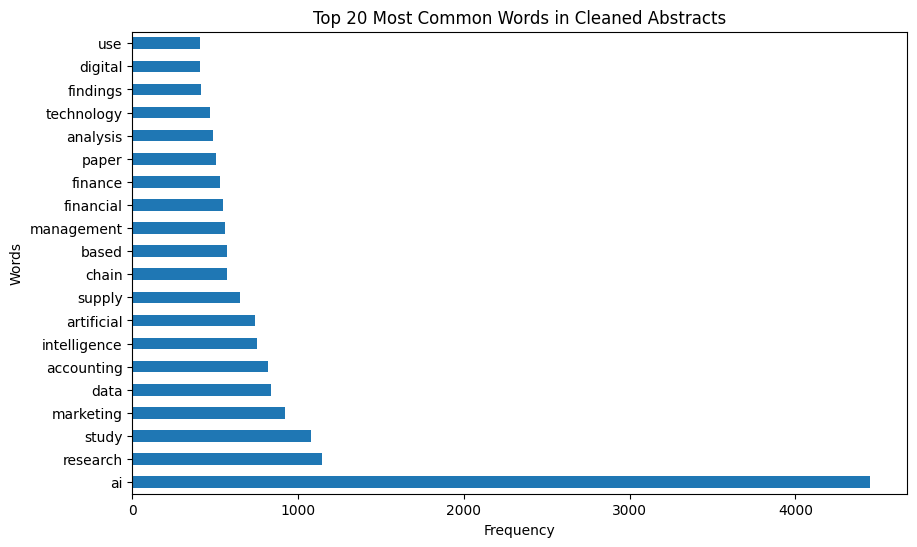

In [27]:
#count the number of times each word appears in the cleaned abstracts
word_counts = pd.Series(' '.join(clean_df['Cleaned Abstract']).split()).value_counts()

#plot the top 20 most common words
import matplotlib.pyplot as plt
word_counts.head(20).plot(kind='barh', figsize=(10, 6))
plt.title('Top 20 Most Common Words in Cleaned Abstracts')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [36]:
# Remove the term "ai" from the cleaned abstracts in partition_df
partition_df['Partitioned Abstract'] = partition_df['Partitioned Abstract'].str.replace(r'\bai\b', '', regex=True)
# Remove the term "research" and "study" from the cleaned abstracts in partition_df
partition_df['Partitioned Abstract'] = partition_df['Partitioned Abstract'].str.replace(r'\bresearch\b', '', regex=True)
partition_df['Partitioned Abstract'] = partition_df['Partitioned Abstract'].str.replace(r'\bstudy\b', '', regex=True)
# Save the partitioned DataFrame to a CSV file
partition_df.to_csv(f'{directory}/Partitioned_Abstracts.csv', index=False, encoding='utf-8-sig')

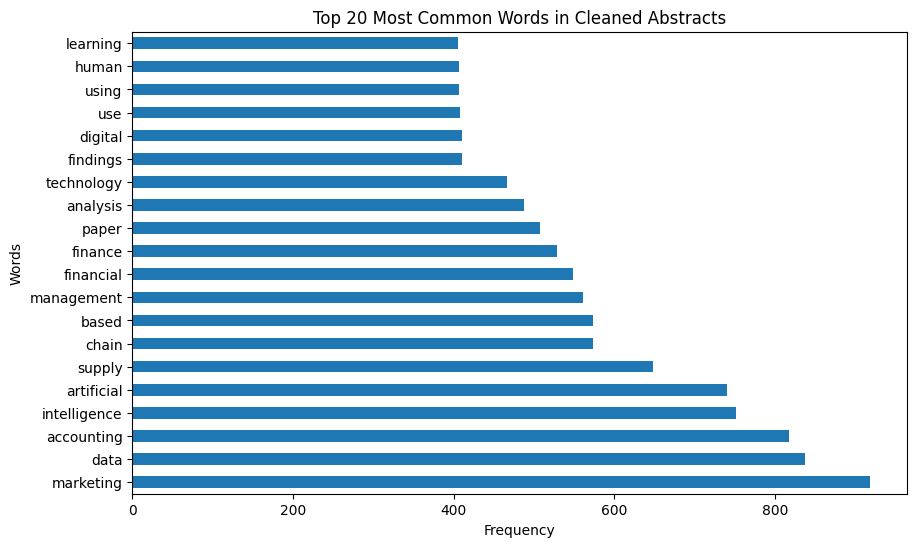

In [37]:
#count the number of times each word appears in the partitioned abstracts\
word_counts = pd.Series(' '.join(partition_df['Partitioned Abstract']).split()).value_counts()


#plot the top 20 most common words
import matplotlib.pyplot as plt
word_counts.head(20).plot(kind='barh', figsize=(10, 6))
plt.title('Top 20 Most Common Words in Cleaned Abstracts')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [33]:
partition_df

,Title,Year,Authors,Label,Partitioned Abstract,Target
0,THE IMPACT OF AI DEVELOPMENT ON THE DEVELOPMEN...,2023,"Nesterenko, V; Olefirenko, O",AI and Marketing,advertising always remains important part comp...,2
1,Exploring volatility interconnections between ...,2024,"Yousaf, I; Ijaz, MS; Umar, M; Li, YS",AI and Finance,aspect potential alter role net transmitter re...,1
2,Implementing Digital Twins That Learn: AI and ...,2023,"Biller, B; Biller, S",AI and Supply Chain Management,companies trying build resilient supply chains...,0
3,The Future of Marketing and Marketing Education,2025,"Grewal, D; Guha, A; Satornino, CB; Becker, M",AI and Marketing,employers expect university graduates seeking ...,2
4,"Managerial accounting and decision making, in ...",2014,"Mihaila, M",AI and Accounting,managerial accounting branch accounting suppor...,4
...,...,...,...,...,...,...
1223,Forecasting in financial accounting with artif...,2024,"Kureljusic, M; Karger, E",AI and Accounting,researchers address enable frequent efficient ...,4
1224,Optimizing Romanian Managerial Accounting Prac...,2024,"Pantea, MF; Cilan, TF; Cuc, LD; Rad, D; Batca-...",AI and Accounting,rapid advancement big data artificial intellig...,4
1225,Neural Networks in Accounting: Bridging Financ...,2025,"Artene, AE; Domil, AE",AI and Accounting,businesses navigate complexities modern financ...,4
1226,"Framing the Future: The Foundation Series, Fou...",2022,"Williams, C",AI and Economics,risk preserving digital aspic current hegemoni...,3
